In [2]:
!git clone https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 37981, done.
remote: Total 37981 (delta 0), reused 0 (delta 0), pack-reused 37981
Receiving objects: 100% (37981/37981), 544.49 MiB | 47.05 MiB/s, done.
Resolving deltas: 100% (25465/25465), done.


In [10]:
!python /content/models/research/setup.py build
!python /content/models/research/setup.py install

running build
running install
running bdist_egg
running egg_info
creating object_detection.egg-info
writing object_detection.egg-info/PKG-INFO
writing dependency_links to object_detection.egg-info/dependency_links.txt
writing requirements to object_detection.egg-info/requires.txt
writing top-level names to object_detection.egg-info/top_level.txt
writing manifest file 'object_detection.egg-info/SOURCES.txt'
writing manifest file 'object_detection.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib

creating build
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying object_detection.egg-info/PKG-INFO -> build/bdist.linux-x86_64/egg/EGG-INFO
copying object_detection.egg-info/SOURCES.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying object_detection.egg-info/dependency_links.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying object_detection.egg-info/requires.txt -> 

In [12]:
%cd /content/models/research
! protoc object_detection/protos/*.proto --python_out=.
%cd ..
%cd ..
%cd ..

/content/models/research
object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.
/content/models
/content
/


In [14]:
%cd content/models/research
%set_env PYTHONPATH=/content/models/research:/content/models/research/slim



/content/models/research
env: PYTHONPATH=/content/models/research:/content/models/research/slim


In [3]:
%cd /content/models/research/object_detection
# /content/models/research/object_detection/utils

/content/models/research/object_detection


In [8]:
!pip install tf_slim

     |████████████████████████████████| 358kB 2.7MB/s 


In [18]:
import numpy as np
import cv2
import imutils
import time
from sklearn.metrics import pairwise
from imutils.video import FPS
import copy
import os
import sys
import tensorflow as tf
import pathlib
from collections import defaultdict




from utils import ops as utils_ops
from utils import label_map_util
from utils import visualization_utils as vis_util



utils_ops.tf = tf.compat.v1
tf.gfile = tf.io.gfile
PATH_TO_LABELS = '/content/drive/My Drive/alphabt/fin/training/labelmap.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)




model_name = '/content/drive/My Drive/alphabt/trained_model/inference-graph'
model_dir =   model_name + "/saved_model"
detection_model = tf.saved_model.load(str(model_dir))
detection_model = detection_model.signatures['serving_default']



# print(category_index)
colors = np.random.uniform(0, 255, size=(len(category_index), 3))
font = cv2.FONT_HERSHEY_SIMPLEX
blackLower = (0 , 0 , 0)
blackUpper = (180 , 255 , 35)

print(detection_model.inputs)
print(detection_model.output_dtypes)
print(detection_model.output_shapes)






INFO:tensorflow:Saver not created because there are no variables in the graph to restore
[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]
{'raw_detection_scores': tf.float32, 'detection_multiclass_scores': tf.float32, 'detection_classes': tf.float32, 'num_detections': tf.float32, 'detection_boxes': tf.float32, 'raw_detection_boxes': tf.float32, 'detection_scores': tf.float32}
{'raw_detection_scores': TensorShape([None, 300, 3]), 'detection_multiclass_scores': TensorShape([None, 300, 3]), 'detection_classes': TensorShape([None, 300]), 'num_detections': TensorShape([None]), 'detection_boxes': TensorShape([None, 300, 4]), 'raw_detection_boxes': TensorShape([None, 300, 4]), 'detection_scores': TensorShape([None, 300])}


(260, 287, 3)
5 {'raw_detection_scores': array([[0.9754387 , 0.00833348, 0.01622772],
       [0.8114932 , 0.05873165, 0.12977514],
       [0.88315743, 0.03222029, 0.08462232],
       [0.87747806, 0.01673383, 0.10578802],
       [0.77282536, 0.07247543, 0.15469928],
       [0.9289618 , 0.02690538, 0.04413278],
       [0.5629717 , 0.13462318, 0.30240515],
       [0.7686264 , 0.05976471, 0.17160891],
       [0.9264261 , 0.04196587, 0.03160797],
       [0.8998533 , 0.04843032, 0.05171636],
       [0.7707526 , 0.05849056, 0.17075682],
       [0.84474784, 0.06940996, 0.08584227],
       [0.923369  , 0.03899872, 0.03763229],
       [0.86061585, 0.04446831, 0.09491582],
       [0.65813494, 0.13114874, 0.21071628],
       [0.78779626, 0.07991041, 0.13229328],
       [0.87427706, 0.04484233, 0.08088058],
       [0.88469833, 0.04463616, 0.07066551],
       [0.7646351 , 0.06339481, 0.1719701 ],
       [0.89923304, 0.04410774, 0.05665918],
       [0.8208114 , 0.0547027 , 0.12448593],
       [0.9237

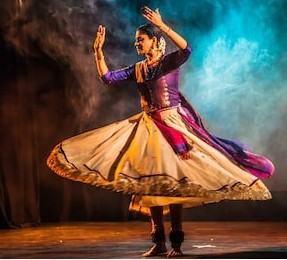

In [21]:




def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  input_tensor = tf.convert_to_tensor(image)
  input_tensor = input_tensor[tf.newaxis,...]



  # output_dict is a dict  with keys detection_classes , num_detections , detection_boxes(4 coordinates of each box) , detection_scores for 100 boxes
  output_dict = model(input_tensor)
  # print(1,output_dict)




  # num_detections gives number of objects in current frame
  num_detections = int(output_dict.pop('num_detections'))
  # print(2,num_detections)



  # output_dict is a dict  with keys detection_classes , detection_boxes(4 coordinates of each box) , detection_scores for num_detections boxes
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}


  # adding num_detections that was earlier popped out
  output_dict['num_detections'] = num_detections


  # converting all values in detection_classes as ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
  print(5,output_dict)



  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])   
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    print(5,detection_masks_reframed) 
  return output_dict





def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  # image_np = np.array(Image.open(image_path))
  image_np = np.array(image_path)
  print(image_np.shape)

  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  return image_np

















from google.colab.patches import cv2_imshow
frame = cv2.imread("/content/models/research/object_detection/test_images/6.jpg")

i=show_inference( detection_model,frame)
cv2_imshow(i)



In [1]:
import tensorflow as tf
tf.__version__


'2.2.0'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
